In [1]:
# 1. Text Processing & NLP Libraries
import re
import spacy
import nltk
from nltk.corpus import stopwords
import gensim
import gensim.corpora as corpora
from gensim.models import Phrases, CoherenceModel
from gensim.models.phrases import Phraser

# 2. Data Manipulation & Analysis
import pandas as pd
import numpy as np

# 3. Visualization Libraries
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import pyLDAvis.lda_model

# 4. Machine Learning & Vectorization
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation, TruncatedSVD, NMF
from sklearn.manifold import TSNE

# 5. Sentiment Analysis
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

# 6. Others
from collections import Counter



# Load Data Loading

In [2]:
df = pd.read_csv('Reviews.csv')
df.head()

,Unnamed: 0,Review,Seat Type
0,0,No staff at the transfer desk to issue board...,Economy Class
1,1,It would appear that Ryanair have produced a...,Economy Class
2,2,I was on a 3-month trip with most of my favo...,Economy Class
3,3,Excellent and professional. We had our child...,Economy Class
4,4,One of the worst experiences ever. Hardly an...,Economy Class


# Data Slitting based on Different Flight Classes

In [3]:
# Divide into sub-datasets based on different categories in the 'Seat Type' column
economy_class_df = df[(df['Seat Type'] == 'Economy Class') | (df['Seat Type'] == 'Premium Economy')]
business_class_df = df[df['Seat Type'] == 'Business Class']
first_class_df = df[df['Seat Type'] == 'First Class']

In [4]:
# Save to a CSV file
economy_class_df.to_csv('economy_class_df.csv', index=True)
business_class_df.to_csv('business_class_df.csv', index=True)
first_class_df.to_csv('first_class_df.csv', index=True)

In [5]:
print(f"The portion of economy class: {len(economy_class_df)/len(df):.2f}\n")
print(f"The portion of business class: {len(business_class_df)/len(df):.2f}\n")
print(f"The portion of first class: {len(first_class_df)/len(df):.2f}")

The portion of economy class: 0.68

The portion of business class: 0.29

The portion of first class: 0.03


# Data Pre-processing

This section is to normalize data.
1) Tokenization: A piece of text review is separated into single units, for
example, “Excellent and professional” is tokenized into “excellent”, “and”,
“professional”.
2) Noise Removal: Non-informative features are reduced by removing
punctuation marks and meaningless symbols such as e-mails.
Moreover, we lowercase the words to normalize texts.
3) Stop Words Removal: Common English stop words, including "is", "the",
and "a", are eliminated as they cannot contribute significant semantic
value.
4) Shorter-length Words Removal: We filter out short words with fewer
than three characters for dataset purification since these words generally
lack substantial semantic content and would introduce noise.
5) Lemmatization: Lemmatization can be used to transform different word
variations into their base form. For example, "running" and "ran" are
transformed to "run". This can reduce the vocabulary size and enhance
text consistency.

In [6]:
# Get English stopwords
stop_words = set(stopwords.words('english'))  

# Load SpaCy model
nlp = spacy.load('en_core_web_sm')  

# Preprocessing function
def preprocess(doc):
    
    # Remove email addresses
    doc = re.sub(r'\S*@\S*\s?', '', doc)
    
    # Process the document using SpaCy
    spacy_doc = nlp(doc)
    
    # Lemmatize tokens, keep only alphabetic tokens of length >= 3
    lemmatized_tokens = [token.lemma_ for token in spacy_doc if token.is_alpha and len(token) >= 3]
    
    # Convert tokens to lowercase and remove stopwords
    cleaned_tokens = [token.lower() for token in lemmatized_tokens if token.lower() not in stop_words]
    
    return cleaned_tokens

In [7]:
# Apply preprocessing function
df['Processed_comments'] = df['Review'].apply(preprocess)
df.head()

,Unnamed: 0,Review,Seat Type,Processed_comments
0,0,No staff at the transfer desk to issue board...,Economy Class,"[staff, transfer, desk, issue, boarding, pass,..."
1,1,It would appear that Ryanair have produced a...,Economy Class,"[would, appear, ryanair, produce, race, bottom..."
2,2,I was on a 3-month trip with most of my favo...,Economy Class,"[month, trip, favorite, clothe, air, transat, ..."
3,3,Excellent and professional. We had our child...,Economy Class,"[excellent, professional, child, fly, illinois..."
4,4,One of the worst experiences ever. Hardly an...,Economy Class,"[one, bad, experience, ever, hardly, anything,..."


# N-Grams

The proposed N-Gram feature extraction could be implemented in two stages:
1) Phrase Identification: use semantic N-Gram phrase identification after data
cleaning.
2) Phrase Refinement: use the Pointwise Mutual Information (PMI) and Log Biased Mutual Dependency (LBGD) for phrase refinement.

In [8]:
# Define the LBMD (Logarithmic Bigram Mutual Dependency) function
def lbmd(worda_count, wordb_count, bigram_count, len_vocab, min_count, corpus_word_count, delta=1):
    # Calculate probabilities
    # Joint probability of A and B co-occurrce (bigram)
    p_xy = bigram_count / corpus_word_count  
    
    # Probability of word A occurring
    p_x = worda_count / corpus_word_count  
    
    # Probability of word B occurring
    p_y = wordb_count / corpus_word_count  
    
    # Return the LBMD score
    return np.log(p_xy + delta) - np.log(p_x * p_y + delta)

#  N-grams (bigrams and trigrams) functions using PMI and LBMD
def make_n_grams(texts, min_count=10, threshold=0.3):
    
    # Detect bigrams using normalized PMI 
    bigram = Phrases(texts, min_count=min_count, threshold=threshold, scoring='npmi')
    bigram_mod = Phraser(bigram) 
    
    # Detect trigrams using LBMD 
    trigram = Phrases(bigram[texts], threshold=50, scoring=lbmd) 
    trigram_mod = Phraser(trigram) 
    
    # Apply the bigram and trigram models to the tokenized texts
    bigrams_text = [bigram_mod[doc] for doc in texts] 
    trigrams_text = [trigram_mod[bigram_mod[doc]] for doc in bigrams_text]
    
    return trigrams_text  # Return texts containing bigrams and trigrams

# Apply the N-gram fucntion to processed comments
tokens_reviews = make_n_grams(df['Processed_comments'])

# Rejoin the tokenized N-grams into full sentences for Bag of Words
tokens_reviews_joined = [' '.join(doc) for doc in tokens_reviews]

In [9]:
print(f"Original Review: {df['Review'][0]} \n")
print(f"Pre-processing Tokens: {df['Processed_comments'][0]} \n")
print(f"N-Grams Tokens: {tokens_reviews[0]} \n")

Original Review:   No staff at the transfer desk to issue boarding pass. I was told to proceed to the boarding gate for service. After one hour of waiting in a queue, several people including me were finally get their passes. While we were lining up, many travellers (probably first and business class) cut the queue to insist on going to the aircraft first.  From what I feel, they need a bigger crew to service the A380. Staff avoided eye contact with me to speed up their service. Food was not ready for the first meal. I had to wait half an hour for my main meal after finishing everything else. I was not offered a drink and when I asked, they signalled me to wait. I waited for another half an hour without any drink from the crew yet the guy two rows in front of me asked for a refill and was offered immediately. Second meal was a total disaster, it took an hour for our cabin to be served. To the point that, many people who were already served, they expected their trays to be cleared but n

# Word Coud & Frequency Analysis Table

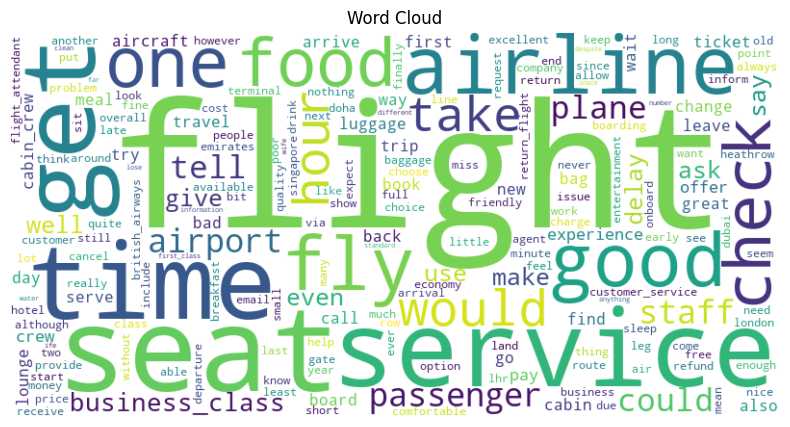

In [10]:
# List containing of tokens
all_words = [word for review in tokens_reviews for word in review]

# Calculate the frequency of each token
word_counts = Counter(all_words)

# Get the top 100 most frequent tokens
top_100_words = word_counts.most_common(100)
df_top_100_words = pd.DataFrame(top_100_words, columns=['Word', 'Frequency'])

# save frequency analysis results
df_top_100_words.to_csv('df_top_100_words.csv', index=True)

# Generate a word cloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(word_counts)

# Display the word cloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off') 
plt.title('Word Cloud')
plt.show()


# Feature Etraction

The Bag of Words (BoW) is used for feature extraction, transforming textual data into numerical vectors based on word frequency.

In [11]:
# Initialize CountVectorizer for text vectorization
vectorizer = CountVectorizer(
    analyzer='word',                # Analyze words 
    ngram_range=(1, 3),             # Extract 1-grams, 2-grams, and 3-grams
    min_df=10)                      # Ignore terms that appear in fewer than 10 documents

# Fit the vectorizer to the data and transform the tokenized and joined reviews into a document-term matrix
data_vectorized = vectorizer.fit_transform(tokens_reviews_joined)

In [12]:
# Create a dictionary based on the tokenized reviews
id2word = corpora.Dictionary(tokens_reviews)

# Topic Modeling

Coherence values assess semantic similarity between words within topics, where a higher coherence score reflects a tighter semantic relationship among the words within a topic.

In [13]:
def compute_coherence_values(model_type, data_vectorized, texts, dictionary, vectorizer, start=2, limit=15, step=1, random_state=42):
    """
    Compute coherence values of three models with different topic numbers.

    Parameters:
    - model_type: LDA, LSA, NMF
    - data_vectorized: Document-term matrix
    - texts: Tokenized texts after pre-processing
    - dictionary: Gensim dictionary based on the tokenized texts
    - vectorizer: CountVectorizer
    - start: Minimum topic number
    - limit: Maximum topic number 
    - step: Step size for different topic numbers
    - random_state: Random seed for reproducibility

    Returns:
    - coherence_values: A list of coherence values for different numbers of topics
    """
    
    # Initialize an empty list for coherence values
    coherence_values = []
    
    # The range of topic numbers
    topic_numbers = range(start, limit, step)

    for num_topics in topic_numbers:
        # Initialize the respective topic model
        if model_type == 'lda':
            model = LatentDirichletAllocation(n_components=num_topics, random_state=random_state)
        elif model_type == 'lsa':
            model = TruncatedSVD(n_components=num_topics, random_state=random_state)
        elif model_type == 'nmf':
            model = NMF(n_components=num_topics, random_state=random_state)
        else:
            raise ValueError("Model type must be 'lda', 'lsa' or 'nmf'")

        # Fit the model to the vectorized data and transform the data
        model_output = model.fit_transform(data_vectorized)

        # Extract the top words from each topic
        topics = []
        for topic in model.components_:
            # Get the top 10 words for each topic
            top_words = [vectorizer.get_feature_names_out()[i] for i in topic.argsort()[:-11:-1]]
            topics.append(top_words)

        # Compute coherence value using Gensim's CoherenceModel
        coherence_model = CoherenceModel(topics=topics, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence = coherence_model.get_coherence()
        coherence_values.append(coherence) 

    # Return the topic numbers and their corresponding coherence values
    return topic_numbers, coherence_values

In [14]:
# Apply compute_coherence_values function
lda_topic_numbers, lda_coherences = compute_coherence_values('lda', data_vectorized, tokens_reviews, id2word, vectorizer, start=6, limit=16)
lsa_topic_numbers, lsa_coherences = compute_coherence_values('lsa', data_vectorized, tokens_reviews, id2word, vectorizer, start=6, limit=16)
nmf_topic_numbers, nmf_coherences = compute_coherence_values('nmf', data_vectorized, tokens_reviews, id2word, vectorizer, start=6, limit=16)

/Users/lizihe/anaconda3/lib/python3.10/site-packages/sklearn/decomposition/_nmf.py:1710: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
/Users/lizihe/anaconda3/lib/python3.10/site-packages/sklearn/decomposition/_nmf.py:1710: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


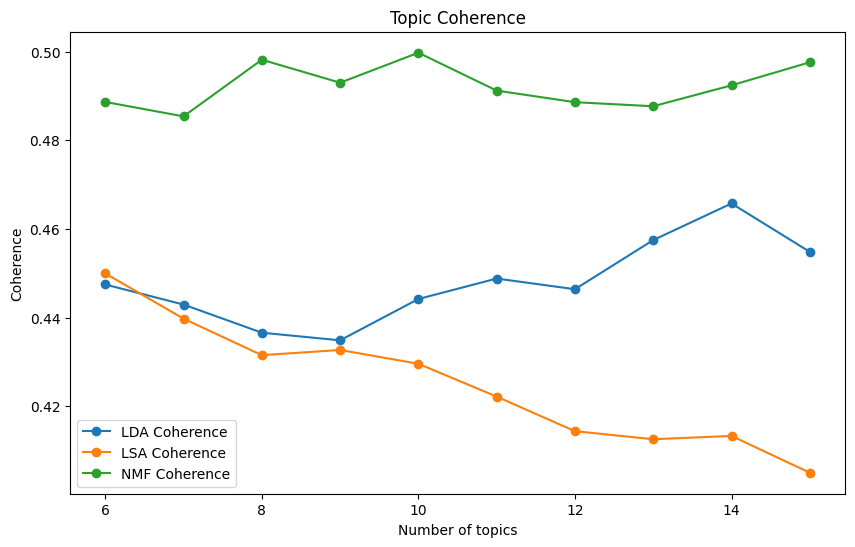

In [15]:
# Visualize the coherence scores of three models
plt.figure(figsize=(10, 6))

plt.plot(lda_topic_numbers, lda_coherences, marker='o', label='LDA Coherence')
plt.plot(lsa_topic_numbers, lsa_coherences, marker='o', label='LSA Coherence')
plt.plot(nmf_topic_numbers, nmf_coherences, marker='o', label='NMF Coherence')

plt.title('Topic Coherence')
plt.xlabel('Number of topics')
plt.ylabel('Coherence')
plt.legend()

plt.show()

In [16]:
print(f"lda coherences: {lda_coherences} \n")
print(f"lsa coherences: {lsa_coherences} \n")
print(f"nmf coherences: {nmf_coherences} \n")

lda coherences: [0.4474833300815411, 0.44295818431729284, 0.4366138723300486, 0.4348943534557643, 0.44421405619255216, 0.44882160874852506, 0.44641855520310453, 0.4574991346074789, 0.46575195899286875, 0.45483692389598496] 

lsa coherences: [0.4499778674055142, 0.4397811959871588, 0.43154571644927797, 0.4327203346652581, 0.42960152268911395, 0.4222103511367353, 0.4144093151538097, 0.41259359236773807, 0.4133345286829956, 0.40504312487168603] 

nmf coherences: [0.48864728494198423, 0.4853876706826558, 0.4981640969848522, 0.4929794460670505, 0.4997411647112905, 0.49120241713045326, 0.4885894772444202, 0.48767168996966226, 0.49238883261746114, 0.49758425737333306] 



## The Optimal LDA Model Visualization

PyLDAvis effectively illustrates the distribution of
terms related to each topic and their relative prevalence. Additionally, it
uses a Cartesian diagram to compare the similarities between different topics. It projects high-dimensional topic space into two dimensions, where each
topic is described as a circle. The size of a circle corresponds to the weight of that topic in the document. The similarity between topics is determined by the
distance and overlap of their circles. Circles with a far distance represent quite
different topics, while circles with a close distance or overlap with each other
indicate similar topics.

In [17]:
# Initialize the optimal LDA model with 14 topics
optimal_lda_model = LatentDirichletAllocation(n_components=14, random_state=42)

# Transform the data into topic distributions
optimal_lda_output = optimal_lda_model.fit_transform(data_vectorized)

# Use pyLDAvis for LDA visualization
pyLDAvis.enable_notebook()

# Use t-SNE for dimensionality reduction
panel = pyLDAvis.lda_model.prepare(optimal_lda_model, data_vectorized, vectorizer, mds='tsne')

# Display visualization 
pyLDAvis.display(panel)


In [18]:
# 设定λ值，λ=1时只看词频，λ=0时只看特异性
lambda_value = 1  # 可以调整

# 从pyLDAvis面板中提取数据
lda_topic_info = panel.topic_info

# 按主题提取单词
for topic_id in range(1, optimal_lda_model.n_components + 1):
    print(f"Topic {topic_id}:")
    
    # 过滤出当前主题相关的词
    current_topic_words = lda_topic_info[(lda_topic_info.Category == f'Topic{topic_id}')]
    
    # 计算综合相关性（relevance metric），并根据相关性排序
    current_topic_words['relevance'] = current_topic_words['loglift'] * (1 - lambda_value) + current_topic_words['logprob'] * lambda_value
    sorted_words = current_topic_words.sort_values(by='relevance', ascending=False)
    
    # 输出前10个单词
    print(sorted_words['Term'].head(10).tolist())
    print("\n")

Topic 1:
['flight', 'delay', 'hour', 'airport', 'get', 'tell', 'time', 'plane', 'would', 'take']


Topic 2:
['flight', 'get', 'book', 'ticket', 'call', 'cancel', 'change', 'refund', 'tell', 'customer_service']


Topic 3:
['flight', 'good', 'service', 'seat', 'food', 'great', 'business_class', 'cabin', 'meal', 'fly']


Topic 4:
['luggage', 'bag', 'check', 'airline', 'get', 'baggage', 'pay', 'say', 'airport', 'one']


Topic 5:
['seat', 'flight', 'good', 'get', 'business_class', 'food', 'plane', 'service', 'one', 'old']


Topic 6:
['meal', 'food', 'service', 'ask', 'serve', 'drink', 'flight', 'get', 'take', 'passenger']


Topic 7:
['flight', 'good', 'service', 'food', 'excellent', 'fly', 'airline', 'staff', 'lounge', 'comfortable']


Topic 8:
['airline', 'fly', 'flight', 'service', 'bad', 'even', 'travel', 'time', 'use', 'hour']


Topic 9:
['flight', 'fly', 'food', 'british_airways', 'seat', 'economy', 'service', 'airline', 'business_class', 'well']


Topic 10:
['check', 'lounge', 'passen

/var/folders/xt/6qqzshns5jjgd_0j2nczcc400000gn/T/ipykernel_5543/794043315.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  current_topic_words['relevance'] = current_topic_words['loglift'] * (1 - lambda_value) + current_topic_words['logprob'] * lambda_value
/var/folders/xt/6qqzshns5jjgd_0j2nczcc400000gn/T/ipykernel_5543/794043315.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  current_topic_words['relevance'] = current_topic_words['loglift'] * (1 - lambda_value) + current_topic_words['logprob'] * l

## The Optimal LSA Model Visualization

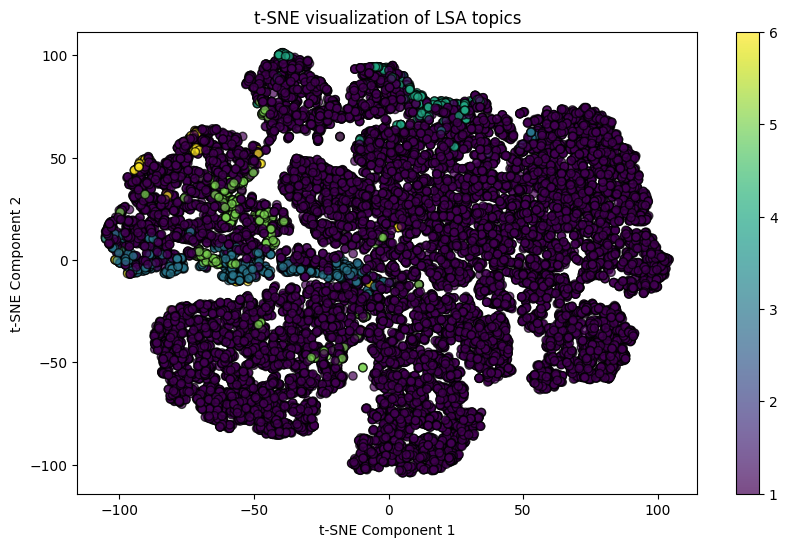

In [19]:
# Initialize the optimal LSA model with 6 components
optimal_lsa_model = TruncatedSVD(n_components=6, random_state=42)

# Transform the data into topic distributions
optimal_lsa_output = optimal_lsa_model.fit_transform(data_vectorized)

# Use t-SNE to reduce the output to 2D for visualization
lsa_tsne_model = TSNE(n_components=2, random_state=42)
lsa_tsne_values = lsa_tsne_model.fit_transform(optimal_lsa_output)

# Assign each document to a topic by starting topic IDs from 1
lsa_topics = np.argmax(optimal_lsa_output, axis=1) + 1 

# t-SNE Visualization
plt.figure(figsize=(10, 6)) 
plt.scatter(lsa_tsne_values[:, 0], lsa_tsne_values[:, 1], c=lsa_topics, cmap='viridis', marker='o', edgecolor='k', alpha=0.7)
plt.colorbar()
plt.title('t-SNE visualization of LSA topics')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.show()


In [27]:
def extract_topics(model, feature_names, topic_values, num_top_words=10):
    """
    Extract topic information containing "Topic", "Topic Title", "Key Words", and "Topic Share (%)"

    Parameters:
    - model: LSA, NMF
    - feature_names: List of feature names from CountVectorizer
    - topic_values: Document-term matrix
    - num_top_words: Top 10 keywords

    Returns:
    - topic_df: Data Frame containing "Topic", "Topic Title", "Key Words", and "Topic Share (%)"
    """
    
    # List of top words for each topic
    topic_words = []
    
    for topic_idx, topic in enumerate(model.components_):
        # Index of the top words for the topic
        top_features_ind = topic.argsort()[:-num_top_words - 1:-1]
        
        # Map the indexs to the features
        top_features = [feature_names[i] for i in top_features_ind]
        topic_words.append(", ".join(top_features))
    
    # Calculate topic proportions
    topic_proportions = np.mean(np.abs(topic_values), axis=0)
    
    # Normalize topic proportions 
    topic_proportions /= topic_proportions.sum()
    
    # Convert proportions to percentages
    topic_proportions *= 100
    
    # Summarize topic information
    topic_data = {
        "Topic ID": [i+1 for i in range(len(model.components_))],  # Topic number
        "Topic Title": [f"Topic {i+1}" for i in range(len(model.components_))],  # Placeholder for topic label
        "Key Words": topic_words,  # List of top words for each topic
        "Topic Share (%)": [f"{prop:.2f}%" for prop in topic_proportions]  # Topic proportions as percentages
    }

    topic_df = pd.DataFrame(topic_data)
    
    return topic_df  

# Apply extract_topics function to the LSA
lsa_topic_df = extract_topics(optimal_lsa_model, vectorizer.get_feature_names_out(), optimal_lsa_output)

# Save to a CSV file
lsa_topic_df.to_csv('lsa_topic_df.csv', index=True)  # Save with an index

lsa_topic_df

,Topic ID,Topic Title,Key Words,Topic Share (%)
0,1,Topic 1,"flight, seat, get, time, service, airline, one...",42.91%
1,2,Topic 2,"flight, delay, tell, airport, cancel, book, ho...",15.35%
2,3,Topic 3,"get, tell, say, would, call, ask, could, ticke...",13.34%
3,4,Topic 4,"seat, flight, book, pay, change, refund, row, ...",10.64%
4,5,Topic 5,"airline, fly, service, ticket, book, refund, c...",9.12%
5,6,Topic 6,"get, service, good, call, business_class, tell...",8.64%


## The Optimal NMF Model Visualization

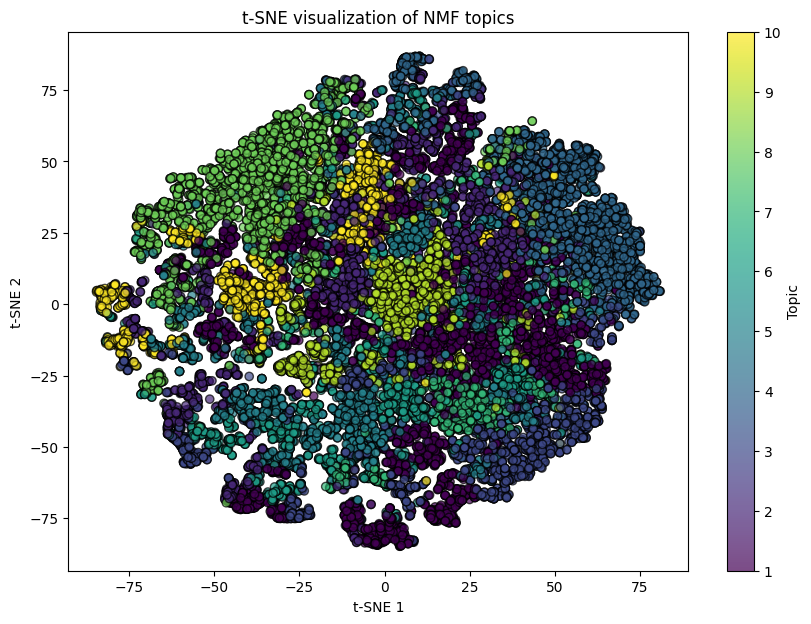

In [28]:
# Initialize the optimal NMF model with 10 components
optimal_nmf_model = NMF(n_components=10, random_state=42)
# Document-topic matrix (W)  
W = optimal_nmf_model.fit_transform(data_vectorized)
# Topic-word matrix (H)
H = optimal_nmf_model.components_

# Use t-SNE to reduce the output to 2D for visualization
nmf_tsne_model = TSNE(n_components=2, perplexity=30, learning_rate=200, n_iter=1000, random_state=42)
nmf_tsne_values = nmf_tsne_model.fit_transform(W)

# t-SNE Visualization
plt.figure(figsize=(10, 7))
plt.scatter(nmf_tsne_values[:, 0], nmf_tsne_values[:, 1], c=W.argmax(axis=1)+1, cmap='viridis', marker='o', edgecolor='k', alpha=0.7)
plt.colorbar(label='Topic')
plt.title('t-SNE visualization of NMF topics')
plt.xlabel('t-SNE 1')
plt.ylabel('t-SNE 2')
plt.show()

In [29]:
# Apply extract_topics function to the NMF
topics_df_nmf = extract_topics(optimal_nmf_model, vectorizer.get_feature_names_out(), W)

# Save to a CSV file
topics_df_nmf.to_csv('nmf_topic_df.csv', index=True)
topics_df_nmf

,Topic ID,Topic Title,Key Words,Topic Share (%)
0,1,Topic 1,"flight, hour, delay, book, cancel, day, hour f...",17.17%
1,2,Topic 2,"business_class, passenger, food, one, crew, of...",10.54%
2,3,Topic 3,"tell, would, say, call, ticket, could, ask, bo...",9.87%
3,4,Topic 4,"seat, pay, plane, row, economy, sit, check, bu...",11.11%
4,5,Topic 5,"airline, fly, even, travel, use, pay, bad, exp...",10.02%
5,6,Topic 6,"check, airport, staff, luggage, bag, passenger...",8.43%
6,7,Topic 7,"get, plane, back, go, hour, one, try, people, ...",7.38%
7,8,Topic 8,"good, food, lounge, great, excellent, well, st...",9.42%
8,9,Topic 9,"time, take, fly, flight time, plane, hour, min...",8.81%
9,10,Topic 10,"service, meal, excellent, provide, drink, offe...",7.26%


# Sentiment Analysis

VADER outputs four components for each word: the breakdown of positive,
negative, and neutral sentiment scores, combined with a compound sentiment
score. The compound score represents an overall sentiment evaluation,
ranging between -1 and + 1, which integrates positive and negative scores
along with other sentiment features like intensity. A compound score closer to
+1 indicates a strongly positive emotion, while a score near -1 reflects a
strongly negative emotion.

In [30]:
# Topic labels
new_labels = {
    1: 'Flight Cancellation and Delay',        # Label for Topic 1
    2: 'Extra Service',          # Label for Topic 2
    3: 'Ticketing',    # Label for Topic 3
    4: 'Comparison of Classes',             # Label for Topic 4
    5: 'Value for Money',           # Label for Topic 5
    6: 'Check-in and Baggage Handling',               # Label for Topic 6
    7: 'Flight Scheduling',              # Label for Topic 7
    8: 'Service Quality',         # Label for Topic 8
    9: 'Flight Scheduling and Delays',             # Label for Topic 9
    10: 'Food and Beverage'           # Label for Topic 10
}

# Map the 'Topic Label' to 'New Labels'
topics_df_nmf['Topic Title'] = topics_df_nmf['Topic ID'].map(lambda x: f'Topic {x}: {new_labels[x]}')

topics_df_nmf

,Topic ID,Topic Title,Key Words,Topic Share (%)
0,1,Topic 1: Flight Cancellation and Delay,"flight, hour, delay, book, cancel, day, hour f...",17.17%
1,2,Topic 2: Extra Service,"business_class, passenger, food, one, crew, of...",10.54%
2,3,Topic 3: Ticketing,"tell, would, say, call, ticket, could, ask, bo...",9.87%
3,4,Topic 4: Comparison of Classes,"seat, pay, plane, row, economy, sit, check, bu...",11.11%
4,5,Topic 5: Value for Money,"airline, fly, even, travel, use, pay, bad, exp...",10.02%
5,6,Topic 6: Check-in and Baggage Handling,"check, airport, staff, luggage, bag, passenger...",8.43%
6,7,Topic 7: Flight Scheduling,"get, plane, back, go, hour, one, try, people, ...",7.38%
7,8,Topic 8: Service Quality,"good, food, lounge, great, excellent, well, st...",9.42%
8,9,Topic 9: Flight Scheduling and Delays,"time, take, fly, flight time, plane, hour, min...",8.81%
9,10,Topic 10: Food and Beverage,"service, meal, excellent, provide, drink, offe...",7.26%


In [32]:
# Initialize VADER sentiment analyzer
sid = SentimentIntensityAnalyzer()

def analyze_sentiment(topic_words):
    # Split the topic words
    words = topic_words.split(', ')
    
    # Apply VADER sentiment analysis to each term
    sentiments = [sid.polarity_scores(word) for word in words]
    
    # Calculate the average sentiment scores of all terms in a set of topic
    avg_sentiment = {
        'pos': sum([s['pos'] for s in sentiments]) / len(sentiments),         # Average positive score
        'neu': sum([s['neu'] for s in sentiments]) / len(sentiments),         # Average neutral score
        'neg': sum([s['neg'] for s in sentiments]) / len(sentiments),         # Average negative score
        'compound': sum([s['compound'] for s in sentiments]) / len(sentiments),  # Average compound score 
    }
    return avg_sentiment  

# Apply sentiment analysis
topics_df_nmf['Sentiment'] = topics_df_nmf['Key Words'].apply(analyze_sentiment)

# Display results
print(topics_df_nmf[['Topic ID', 'Topic Title', 'Sentiment']])


   Topic ID                             Topic Title  \
0         1  Topic 1: Flight Cancellation and Delay   
1         2                  Topic 2: Extra Service   
2         3                      Topic 3: Ticketing   
3         4          Topic 4: Comparison of Classes   
4         5                Topic 5: Value for Money   
5         6  Topic 6: Check-in and Baggage Handling   
6         7              Topic 7: Flight Scheduling   
7         8                Topic 8: Service Quality   
8         9   Topic 9: Flight Scheduling and Delays   
9        10             Topic 10: Food and Beverage   

                                           Sentiment  
0  {'pos': 0.0, 'neu': 0.7, 'neg': 0.3, 'compound...  
1  {'pos': 0.1, 'neu': 0.9, 'neg': 0.0, 'compound...  
2  {'pos': 0.0, 'neu': 1.0, 'neg': 0.0, 'compound...  
3  {'pos': 0.0, 'neu': 0.9, 'neg': 0.1, 'compound...  
4  {'pos': 0.0, 'neu': 0.8, 'neg': 0.2, 'compound...  
5  {'pos': 0.0, 'neu': 1.0, 'neg': 0.0, 'compound...  
6  {'pos'

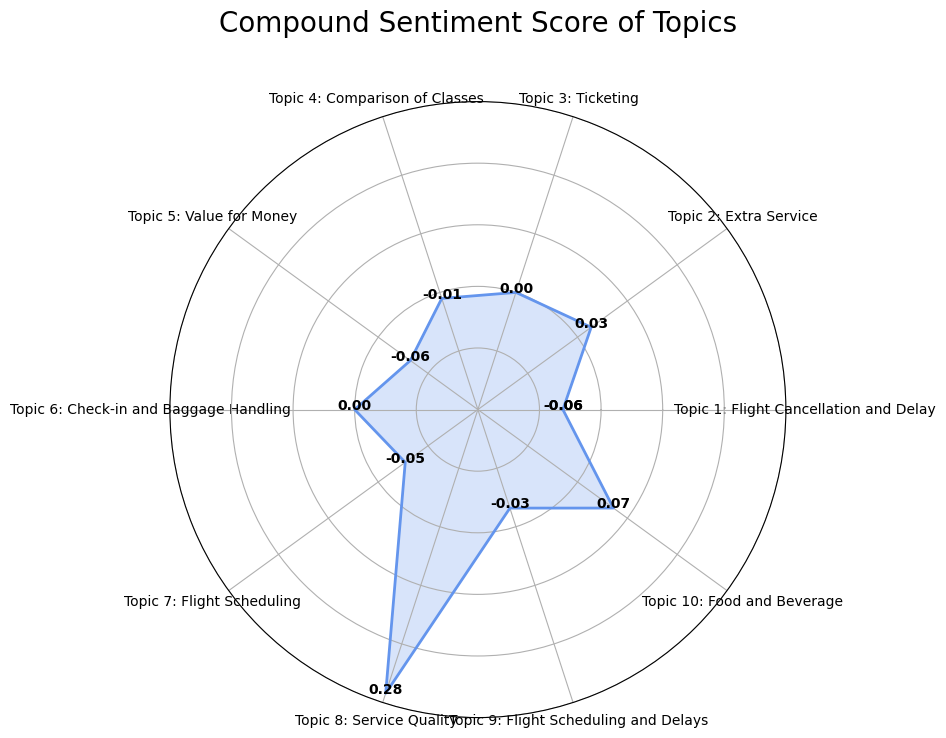

In [33]:
def plot_radar_sentiment(df):
    
    labels = df['Topic Title']
    num_vars = len(labels)  # Number of topics
    
    # Evenly spaced angles for each topic
    angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()
    angles += angles[:1]  # Complete the circle by repeating the first angle
    
    # Scale the compound compound scores
    compound = [s['compound'] * 10 for s in df['Sentiment']]  
    compound += compound[:1]  # Close the circle by repeating the first value
    
    # Initialize the plot
    fig, ax = plt.subplots(figsize=(8, 8), subplot_kw=dict(polar=True))
    
    # Fill and plot the radar chart 
    ax.fill(angles, compound, color='cornflowerblue', alpha=0.25)  
    ax.plot(angles, compound, color='cornflowerblue', linewidth=2)  
    
    # Set the y-axis range for the radar chart
    ax.set_ylim(-2, 3) 
    
    # Remove y-axis tick
    ax.set_yticklabels([])
    
    # Set the x-axis tick labels 
    ax.set_xticks(angles[:-1])  # Filter the repeated angle
    ax.set_xticklabels(labels)  # Label each topic on the radar chart
    
    # Label each point with the compound value
    for i, (angle, score) in enumerate(zip(angles, compound)):
        ax.text(angle, score, f'{score/10:.2f}', horizontalalignment='center', size=10, color='black', weight='semibold')
    plt.title('Compound Sentiment Score of Topics', size=20, color='black', y=1.1)
    plt.show()

# Call the function to plot the radar sentiment chart
plot_radar_sentiment(topics_df_nmf)
